# **NOTE: **
please make sure u are running mel-spegtogram script so the folder have all the data in mel-spectogram u need


Colab Notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install Dependencies



In [ ]:
!pip install torch torchaudio librosa pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
!pip install torchmetrics --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 16.7 MB/s eta 0:00:00


In [ ]:
# Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import librosa
import numpy as np
import os
from sklearn.model_selection import train_test_split
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Definitions

In [ ]:
FOLDER_PATH = "/content/drive/MyDrive/Mezahim Pizuzim Ve Azakot/cnn14_model"
CSV_PATH = "/content/drive/MyDrive/Mezahim Pizuzim Ve Azakot/cnn14_model/labels_cleaned3.csv"
AUDIO_DIR = "/content/drive/MyDrive/Mezahim Pizuzim Ve Azakot/samples"
SPECTROGRAMS_DIR = "/content/drive/MyDrive/Mezahim Pizuzim Ve Azakot/spectrograms"
BEST_MODEL_PATH = "/content/drive/MyDrive/Mezahim Pizuzim Ve Azakot/cnn14_model/best_model_CNN14_Avg.pth"  # Update if your best epoch differs
CSV_UNCLEANED_PATH = "/content/drive/MyDrive/Mezahim Pizuzim Ve Azakot/cnn14_model/labels.csv"
TARGET_TIME_FRAMES = 2000  # Adjust based on your longest audio (e.g., 20s at 96kHz with hop_length=320)

# **Preprocessing**

In [ ]:
def audio_to_melspectrogram(audio_path, spectrograms_dir, sample_rate=32000, n_mels=64, n_fft=1024, hop_length=320, target_frames=2000, augment=False):
    # Generate a unique filename for the spectrogram based on the audio file name
    filename = os.path.splitext(os.path.basename(audio_path))[0]
    spectrogram_path = os.path.join(spectrograms_dir, f"{filename}.npy")

    # Check if the spectrogram already exists
    if os.path.exists(spectrogram_path):
        # Load cached spectrogram
        mel_spec = torch.tensor(np.load(spectrogram_path), dtype=torch.float32)
        # Verify shape matches expected dimensions
        if mel_spec.shape != (1, n_mels, target_frames):
            print(f"Warning: Cached spectrogram {spectrogram_path} has shape {mel_spec.shape}, expected (1, {n_mels}, {target_frames}). Regenerating...")
        else:
            return mel_spec

    # If not cached or shape mismatch, compute the mel-spectrogram
    y, sr = librosa.load(audio_path, sr=sample_rate)
    if augment and np.random.random() < 0.5:  # 50% chance of augmentation
        y = y + np.random.normal(0, 0.01, y.shape)  # Add noise
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-2, 2))  # Pitch shift
    mel_spec = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmin=50, fmax=14000
    )
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    log_mel_spec = (log_mel_spec - log_mel_spec.mean()) / (log_mel_spec.std() + 1e-8)

    # Pad or truncate to target number of frames
    current_frames = log_mel_spec.shape[1]
    if current_frames < target_frames:
        padding = np.zeros((n_mels, target_frames - current_frames))
        log_mel_spec = np.hstack((log_mel_spec, padding))
    elif current_frames > target_frames:
        log_mel_spec = log_mel_spec[:, :target_frames]

    # Convert to tensor and add channel dimension
    mel_spec_tensor = torch.tensor(log_mel_spec, dtype=torch.float32).unsqueeze(0)

    # Save to cache (only if not augmented, to avoid overwriting with augmented versions)
    if not augment:
        os.makedirs(spectrograms_dir, exist_ok=True)
        np.save(spectrogram_path, mel_spec_tensor.numpy())
        print(f"Saved new spectrogram to {spectrogram_path}")
    return mel_spec_tensor

# **Model**

In [ ]:
class CNN14(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN14, self).__init__()
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.AvgPool2d(kernel_size=2, stride=2)
            )
        self.conv_blocks = nn.Sequential(
            conv_block(1, 64), conv_block(64, 128), conv_block(128, 256),
            conv_block(256, 512), conv_block(512, 1024), conv_block(1024, 2048)
        )
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.conv_blocks(x)
        x = x.mean(dim=[2, 3])
        return torch.sigmoid(self.fc(x))

## **DATA-SET**

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, audio_dir, label_dict, spectrograms_dir):
        self.audio_dir = audio_dir
        self.label_dict = label_dict
        self.spectrograms_dir = spectrograms_dir
        self.audio_files = list(label_dict.keys())
        self.labels = list(label_dict.values())
        os.makedirs(spectrograms_dir, exist_ok=True)

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        filename = self.audio_files[idx]
        audio_path = os.path.join(self.audio_dir, filename)
        # Always use caching; augmentation only for training (controlled externally)
        mel_spec = audio_to_melspectrogram(audio_path, self.spectrograms_dir, augment=False)  # Default augment=False
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return mel_spec, label

# **Training**

In [ ]:
def train_model(model, train_loader, val_loader,criterion,optimizer, num_epochs=50, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = model.to(device)
    # criterion = nn.BCELoss()
    # optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)
    early_stopping_patience = 5
    best_val_loss = float('inf')
    patience_counter = 0


    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for mel_specs, labels in train_loader:
            mel_specs, labels = mel_specs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(mel_specs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for mel_specs, labels in val_loader:
                mel_specs, labels = mel_specs.to(device), labels.to(device)
                outputs = model(mel_specs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Save best model and implement early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            print(f"New best model saved with validation loss: {val_loss:.4f} at {BEST_MODEL_PATH}")
        else:
            patience_counter += 1
            print(f"Patience counter: {patience_counter}/{early_stopping_patience}")
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    print(f"Training completed. Best validation loss: {best_val_loss:.4f}")
    return model

# **main - Model Training**
Do not use if you do not want to re-train

Loading CSV from: /content/drive/MyDrive/Mezahim Pizuzim Ve Azakot/cnn14_model/labels_cleaned3.csv
Class distribution (1s per class):
war_sounds    207
animals       417
other         917
dtype: int64
Class weights: tensor([1., 1., 1.], device='cuda:0')
Total samples: 1475
Training samples: 1031, Validation samples: 222, Test samples: 222
Training dataset created with 1031 samples (augmented)
Validation dataset created with 222 samples
Test dataset created with 222 samples
Epoch [1/50], Training Loss: 0.5440
Epoch [1/50], Validation Loss: 0.5841
New best model saved with validation loss: 0.5841 at /content/drive/MyDrive/Mezahim Pizuzim Ve Azakot/cnn14_model/best_model_CNN14_Avg.pth
Epoch [2/50], Training Loss: 0.5110
Epoch [2/50], Validation Loss: 0.5237
New best model saved with validation loss: 0.5237 at /content/drive/MyDrive/Mezahim Pizuzim Ve Azakot/cnn14_model/best_model_CNN14_Avg.pth
Epoch [3/50], Training Loss: 0.4945
Epoch [3/50], Validation Loss: 0.5338
Patience counter: 1/5


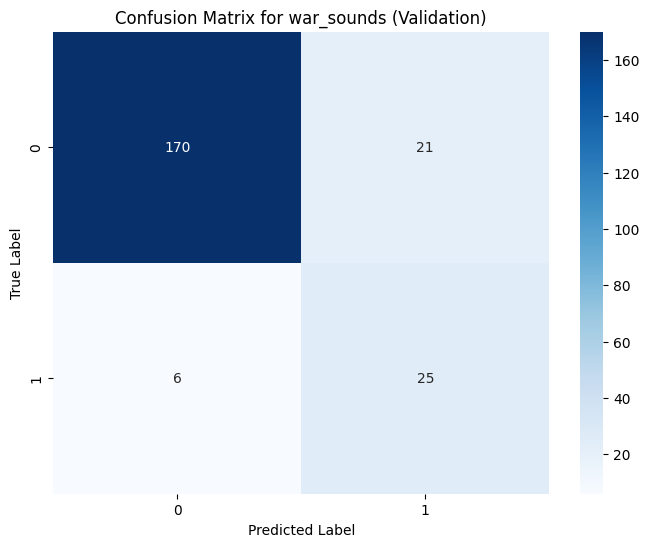

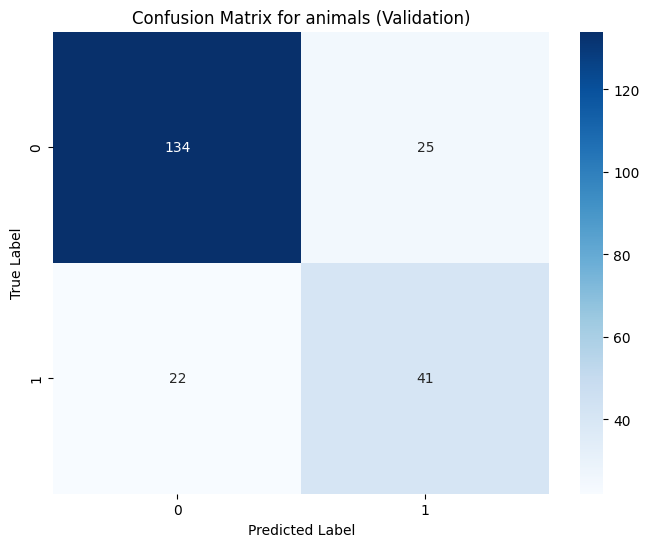

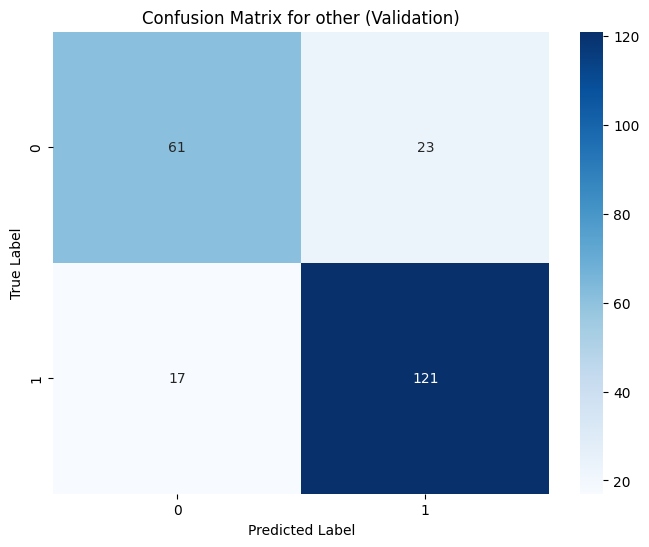

Final Test Loss: 0.3053

Test Metrics:
Test Accuracy for war_sounds: 89.19%
Test Accuracy for animals: 84.23%
Test Accuracy for other: 83.78%
Average Accuracy across classes: 85.74%
Test Precision for war_sounds: 57.45%
Test Precision for animals: 73.33%
Test Precision for other: 85.42%
Average Precision across classes: 72.07%
Test Recall for war_sounds: 87.10%
Test Recall for animals: 69.84%
Test Recall for other: 89.13%
Average Recall across classes: 82.02%
Test F1 for war_sounds: 69.23%
Test F1 for animals: 71.54%
Test F1 for other: 87.23%
Average F1 across classes: 76.00%

Test Confusion Matrices:


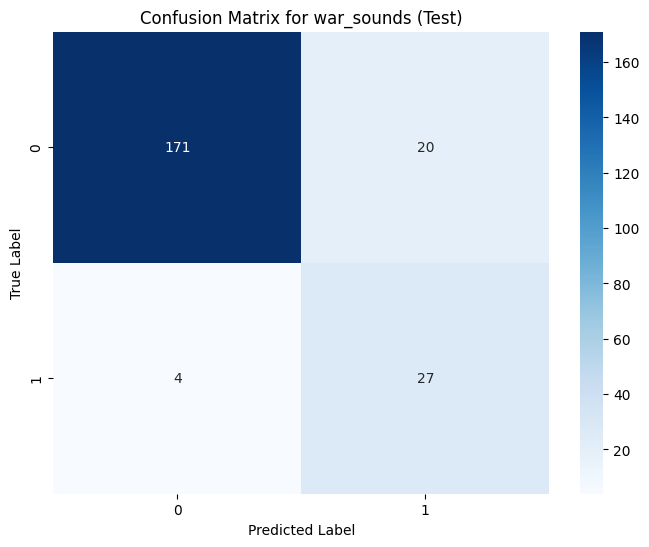

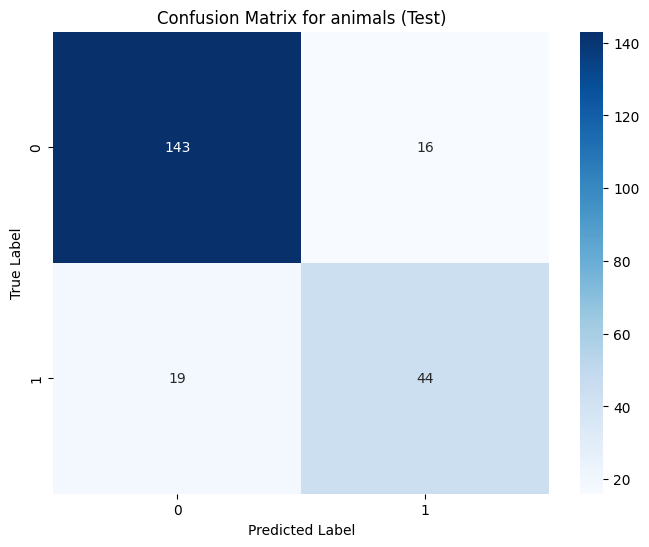

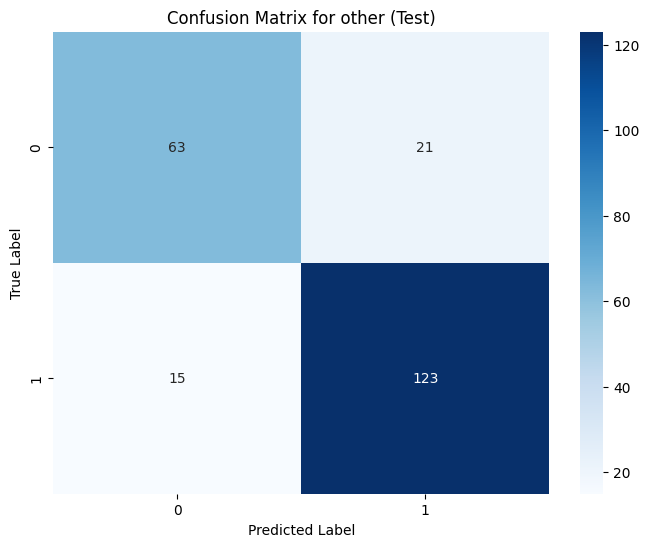

In [ ]:
# Main (with Dynamic Caching, Uniform Size, Data Splitting, Per-Class Metrics, Confusion Matrices, Weighted Loss, and Debugging)
print("Loading CSV from:", CSV_PATH)
try:
    # Define device at the start
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load and prepare data
    df = pd.read_csv(CSV_PATH, encoding='utf-8')

    # Check class distribution
    class_counts = df[["war_sounds", "animals", "other"]].sum()
    print("Class distribution (1s per class):")
    print(class_counts)

    # Calculate class weights (inverse frequency)
    total_samples = len(df)
    class_weights = torch.tensor([
        1.0 ,
        1.0 ,
        1.0 ,
    ], device=device)
    print("Class weights:", class_weights)

    # Create label dictionary and split filenames/labels
    filenames = df["filename"].tolist()
    labels = df[["war_sounds", "animals", "other"]].values.tolist()
    print(f"Total samples: {len(filenames)}")

    # Split into training (70%), validation (15%), and test (15%)
    train_filenames, test_filenames, train_labels, test_labels = train_test_split(
        filenames, labels, test_size=0.15, random_state=42, shuffle=True, stratify=labels
    )
    train_filenames, val_filenames, train_labels, val_labels = train_test_split(
        train_filenames, train_labels, test_size=0.1765, random_state=42, shuffle=True, stratify=train_labels  # 0.1765 ≈ 0.15 / 0.85 for 70/15/15 split
    )
    print(f"Training samples: {len(train_filenames)}, Validation samples: {len(val_filenames)}, Test samples: {len(test_filenames)}")

    # Create label dictionaries for train, validation, and test
    train_label_dict = dict(zip(train_filenames, train_labels))
    val_label_dict = dict(zip(val_filenames, val_labels))
    test_label_dict = dict(zip(test_filenames, test_labels))

    # Verify files for training, validation, and test sets
    train_missing_files = [f for f in train_label_dict.keys() if not os.path.exists(os.path.join(AUDIO_DIR, f))]
    if train_missing_files:
        print(f"Warning: {len(train_missing_files)} training files not found: {train_missing_files[:5]}...")

    val_missing_files = [f for f in val_label_dict.keys() if not os.path.exists(os.path.join(AUDIO_DIR, f))]
    if val_missing_files:
        print(f"Warning: {len(val_missing_files)} validation files not found: {val_missing_files[:5]}...")

    test_missing_files = [f for f in test_label_dict.keys() if not os.path.exists(os.path.join(AUDIO_DIR, f))]
    if test_missing_files:
        print(f"Warning: {len(test_missing_files)} test files not found: {test_missing_files[:5]}...")

    # Setup base training dataset (no augmentation, cached spectrograms)
    base_train_dataset = AudioDataset(AUDIO_DIR, train_label_dict, SPECTROGRAMS_DIR)

    # Wrap training dataset with augmentation (applied dynamically, no caching of augmented versions)
    class AugmentedAudioDataset(Dataset):
        def __init__(self, base_dataset):
            self.base_dataset = base_dataset
        def __len__(self):
            return len(self.base_dataset)
        def __getitem__(self, idx):
            audio_path = os.path.join(self.base_dataset.audio_dir, self.base_dataset.audio_files[idx])
            mel_spec = audio_to_melspectrogram(audio_path, SPECTROGRAMS_DIR, augment=True)
            label = self.base_dataset.labels[idx]
            return mel_spec, torch.tensor(label, dtype=torch.float32)

    train_dataset = AugmentedAudioDataset(base_train_dataset)
    total_train_samples = len(train_dataset)
    print(f"Training dataset created with {total_train_samples} samples (augmented)")

    # Setup validation and test datasets (no augmentation, use cached spectrograms)
    val_dataset = AudioDataset(AUDIO_DIR, val_label_dict, SPECTROGRAMS_DIR)
    total_val_samples = len(val_dataset)
    print(f"Validation dataset created with {total_val_samples} samples")

    test_dataset = AudioDataset(AUDIO_DIR, test_label_dict, SPECTROGRAMS_DIR)
    total_test_samples = len(test_dataset)
    print(f"Test dataset created with {total_test_samples} samples")

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Initialize per-class metrics
    num_classes = 3  # war_sounds, animals, other
    class_names = ["war_sounds", "animals", "other"]
    metrics = {
        "accuracy": BinaryAccuracy(threshold=0.5).to(device),
        "precision": BinaryPrecision(threshold=0.5).to(device),
        "recall": BinaryRecall(threshold=0.5).to(device),
        "f1": BinaryF1Score(threshold=0.5).to(device)
    }

    # Define class-specific thresholds to prioritize recall for war_sounds and animals
    class_thresholds = [0.3, 0.3, 0.5]  # Lower thresholds for war_sounds and animals, default for other

    # Train model with validation, learning rate scheduling, early stopping, and weighted loss
    model = CNN14(num_classes=num_classes)
    model = model.to(device)
    # criterion = nn.BCELoss(weight=class_weights)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Train the model
    model = train_model(model, train_loader, val_loader,criterion,optimizer, num_epochs=50, device=device)

    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_labels = []
    with torch.no_grad():
        for mel_specs, labels in val_loader:
            mel_specs, labels = mel_specs.to(device), labels.to(device)
            outputs = model(mel_specs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            # Apply class-specific thresholds
            preds = torch.zeros_like(outputs)
            for i in range(num_classes):
                preds[:, i] = (outputs[:, i] > class_thresholds[i]).float()
            all_val_preds.append(preds.cpu())
            all_val_labels.append(labels.cpu())

    val_loss /= len(val_loader)
    print(f"Final Validation Loss: {val_loss:.4f}")

    # Compute and print per-class metrics for validation
    all_val_preds = torch.cat(all_val_preds, dim=0)
    all_val_labels = torch.cat(all_val_labels, dim=0)
    print("\nValidation Metrics:")
    for metric_name, metric in metrics.items():
        class_scores = []
        for i in range(num_classes):
            score = metric(all_val_preds[:, i], all_val_labels[:, i])
            if isinstance(score, torch.Tensor):
                score = score.item()  # Ensure scalar value
            class_scores.append(score * 100)  # Convert to percentage
            print(f"Validation {metric_name.capitalize()} for {class_names[i]}: {score * 100:.2f}%")
        print(f"Average {metric_name.capitalize()} across classes: {sum(class_scores) / num_classes:.2f}%")

    # Visualize confusion matrices for validation
    print("\nValidation Confusion Matrices:")
    for i, class_name in enumerate(class_names):
        cm = confusion_matrix(all_val_labels[:, i].numpy(), all_val_preds[:, i].numpy())
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {class_name} (Validation)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    # Evaluate on test set
    model.eval()
    test_loss = 0.0
    all_test_preds = []
    all_test_labels = []
    with torch.no_grad():
        for mel_specs, labels in test_loader:
            mel_specs, labels = mel_specs.to(device), labels.to(device)
            outputs = model(mel_specs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            # Apply class-specific thresholds
            preds = torch.zeros_like(outputs)
            for i in range(num_classes):
                preds[:, i] = (outputs[:, i] > class_thresholds[i]).float()
            all_test_preds.append(preds.cpu())
            all_test_labels.append(labels.cpu())

    test_loss /= len(test_loader)
    print(f"Final Test Loss: {test_loss:.4f}")

    # Compute and print per-class metrics for test
    all_test_preds = torch.cat(all_test_preds, dim=0)
    all_test_labels = torch.cat(all_test_labels, dim=0)
    print("\nTest Metrics:")
    for metric_name, metric in metrics.items():
        class_scores = []
        for i in range(num_classes):
            score = metric(all_test_preds[:, i], all_test_labels[:, i])
            if isinstance(score, torch.Tensor):
                score = score.item()  # Ensure scalar value
            class_scores.append(score * 100)  # Convert to percentage
            print(f"Test {metric_name.capitalize()} for {class_names[i]}: {score * 100:.2f}%")
        print(f"Average {metric_name.capitalize()} across classes: {sum(class_scores) / num_classes:.2f}%")

    # Visualize confusion matrices for test
    print("\nTest Confusion Matrices:")
    for i, class_name in enumerate(class_names):
        cm = confusion_matrix(all_test_labels[:, i].numpy(), all_test_preds[:, i].numpy())
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {class_name} (Test)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

except Exception as e:
    print(f"Error in Main: {e}")
    raise

# PREDICTION USING THE MODEL

---



In [ ]:
def predict_and_update_csv(csv_path, audio_dir, spectrograms_dir, model_path, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    Load CSV_UNCLEANED.CSV, predict labels for all unlabeled samples using the best model,
    and add a new column 'predicted from best model'. Saves the updated CSV with detailed logging.
    """
    # Load the CSV
    print(f"Loading CSV from {csv_path}")
    df = pd.read_csv(csv_path, encoding='utf-8')

    # Load the best model with weights_only=True for safety
    print(f"Loading model from {model_path}")
    try:
        model = CNN14(num_classes=3)  # 3 classes: war_sounds, animals, other
        model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
        model = model.to(device)
        model.eval()
    except Exception as e:
        print(f"Error loading model: {e}")
        raise

    # Initialize the new column
    df["predicted from best model"] = None

    # Counter for debugging
    predicted_count = 0
    skipped_count = 0
    no_audio_count = 0

    # Process each row
    for idx, row in df.iterrows():
        filename = row['filename']
        tag = str(row['tag']) if pd.notna(row['tag']) else None  # Convert tag to string or None

        # Define "unlabeled" as missing tag, empty string, "X", or "0 - other" (no other labels)
        is_unlabeled = (tag is None or tag.strip() == "" or tag == "X" or tag == "0 - other" or tag == "0" or tag == "4")
        # Since war_sounds, animals, other columns might not exist, rely only on tag for now
        print(f"Processing {filename}: Tag={tag}, Is Unlabeled={is_unlabeled}")

        if is_unlabeled:
            # Clean filename to remove macOS ._ prefix if present
            clean_filename = filename.replace("._", "")  # Remove ._ prefix
            audio_path = os.path.join(audio_dir, clean_filename)
            if os.path.exists(audio_path):
                print(f"Found audio file {audio_path}, generating or loading mel-spectrogram...")
                try:
                    # Load or generate mel-spectrogram (cached in SPECTROGRAMS_DIR)
                    mel_spec = audio_to_melspectrogram(audio_path, spectrograms_dir, augment=False)
                    if mel_spec.shape != (1, 64, 2000):
                        print(f"Warning: Mel-spectrogram shape {mel_spec.shape} does not match expected (1, 64, 2000) for {clean_filename}")
                    mel_spec = mel_spec.unsqueeze(0).to(device)  # Add batch dimension

                    # Predict using the model
                    with torch.no_grad():
                        output = model(mel_spec)
                        # Apply class-specific thresholds (0.3 for war_sounds/animals, 0.5 for other)
                        preds = torch.zeros_like(output)
                        class_thresholds = [0.3, 0.3, 0.5]  # war_sounds, animals, other
                        for i in range(3):
                            preds[0, i] = (output[0, i] > class_thresholds[i]).float()

                    # Map predictions to human-readable format
                    prediction = []
                    if preds[0, 0].item() == 1:
                        prediction.append("1 - war")
                    if preds[0, 1].item() == 1:
                        prediction.append("3 - animals")
                    if preds[0, 2].item() == 1:
                        prediction.append("0 - other")

                    # Store prediction
                    pred_str = ", ".join(prediction) if prediction else "0 - other"
                    df.at[idx, "predicted from best model"] = pred_str
                    predicted_count += 1
                    print(f"Predicted for {clean_filename}: {pred_str}")
                except Exception as e:
                    print(f"Error processing {clean_filename}: {e}")
                    df.at[idx, "predicted from best model"] = "0 - other"  # Fallback for errors
            else:
                print(f"Warning: Audio file {audio_path} not found, setting prediction to '0 - other'")
                df.at[idx, "predicted from best model"] = "0 - other"
                no_audio_count += 1
        else:
            # For labeled samples, keep the existing tag
            if pd.notna(tag):
                df.at[idx, "predicted from best model"] = tag
            else:
                df.at[idx, "predicted from best model"] = "0 - other"  # Default for missing tags but labeled
            print(f"Skipping labeled sample {filename} with tag {tag}")

    print(f"Completed predictions: {predicted_count} samples predicted, {no_audio_count} skipped due to missing files, {skipped_count} other skips")

    # Save the updated CSV
    output_csv_path = os.path.join(os.path.dirname(csv_path), "labels_uncleaned_with_predictions.csv")
    df.to_csv(output_csv_path, index=False, encoding='utf-8')
    print(f"Saved updated CSV to {output_csv_path}")

    return output_csv_path

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
updated_csv_path = predict_and_update_csv(CSV_UNCLEANED_PATH, AUDIO_DIR, SPECTROGRAMS_DIR, BEST_MODEL_PATH, device)
print(f"Predictions added to {updated_csv_path}")

Loading CSV from /content/drive/MyDrive/Mezahim Pizuzim Ve Azakot/cnn14_model/labels.csv
Loading model from /content/drive/MyDrive/Mezahim Pizuzim Ve Azakot/cnn14_model/best_model.pth
Processing ._12_20240912_120040.WAV: Tag=0, Is Unlabeled=True
Found audio file /content/drive/MyDrive/Mezahim Pizuzim Ve Azakot/samples/12_20240912_120040.WAV, generating or loading mel-spectrogram...
Predicted for 12_20240912_120040.WAV: 0 - other
Processing ._12_20240912_221920.WAV: Tag=0, Is Unlabeled=True
Found audio file /content/drive/MyDrive/Mezahim Pizuzim Ve Azakot/samples/12_20240912_221920.WAV, generating or loading mel-spectrogram...
Predicted for 12_20240912_221920.WAV: 0 - other
Processing ._12_20240912_224800.WAV: Tag=0, Is Unlabeled=True
Found audio file /content/drive/MyDrive/Mezahim Pizuzim Ve Azakot/samples/12_20240912_224800.WAV, generating or loading mel-spectrogram...
Predicted for 12_20240912_224800.WAV: 0 - other
Processing ._12_20240912_233120.WAV: Tag=0, Is Unlabeled=True
Found a

<ipython-input-61-cdcd69ebda86>:17: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=sample_rate)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Streaming output truncated to the last 5000 lines.
Predicted for 5_20240920_215440.WAV: 0 - other
Processing ._5_20240920_225840.WAV: Tag=None, Is Unlabeled=True
Found audio file /content/drive/MyDrive/Mezahim Pizuzim Ve Azakot/samples/5_20240920_225840.WAV, generating or loading mel-spectrogram...
Predicted for 5_20240920_225840.WAV: 0 - other
Processing ._5_20240920_233200.WAV: Tag=None, Is Unlabeled=True
Found audio file /content/drive/MyDrive/Mezahim Pizuzim Ve Azakot/samples/5_20240920_233200.WAV, generating or loading mel-spectrogram...
Predicted for 5_20240920_233200.WAV: 0 - other
Processing ._5_20240920_234800.WAV: Tag=None, Is Unlabeled=True
Found audio file /content/drive/MyDrive/Mezahim Pizuzim Ve Azakot/samples/5_20240920_234800.WAV, generating or loading mel-spectrogram...
Predicted for 5_20240920_234800.WAV: 0 - other
Processing ._5_20240921_003440.WAV: Tag=None, Is Unlabeled=True
Found audio file /content/drive/MyDrive/Mezahim Pizuzim Ve Azakot/samples/5_20240921_003440